In [1]:
import os
import sys
import time
import shutil
import logging
import argparse
import yaml
import traceback

import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
pwd

'/atlas/u/kechoi/multi-fairgen/notebooks'

In [4]:
cd ../

/atlas/u/kechoi/multi-fairgen


In [5]:
cd src/flows/

/atlas/u/kechoi/multi-fairgen/src/flows


# Dataset

In [6]:
import torch
from torch.distributions import Normal

In [7]:
p = Normal(0, 1)
q = Normal(3, 1)

In [8]:
px = p.sample((2000,2))
qx = q.sample((200,2))

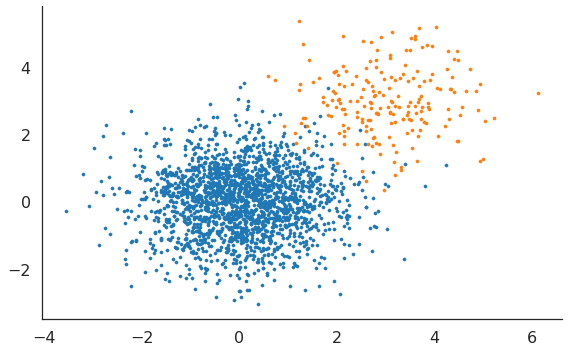

In [9]:
plt.figure(figsize=(8,5))
plt.scatter(px[:,0], px[:,1], label='px', s=10)
plt.scatter(qx[:,0], qx[:,1], label='qx', s=10)

plt.tight_layout()
sns.despine()

In [10]:
true_xs = torch.cat([px, qx])
true_xs.shape

torch.Size([2200, 2])

In [11]:
true_ratios = torch.exp((q.log_prob(true_xs).sum(-1) - p.log_prob(true_xs).sum(-1)))

In [12]:
true_log_ratios = torch.log(true_ratios)

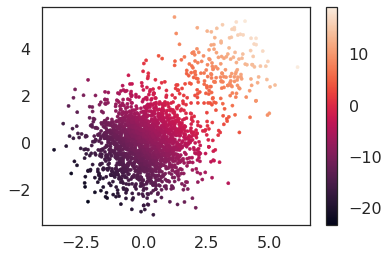

In [13]:
plt.scatter(true_xs[:,0].data.cpu().numpy(), true_xs[:,1].data.cpu().numpy(), s=10, c=true_log_ratios.data.cpu().numpy())
plt.colorbar()

# True ratios

In [14]:
cd ../

/atlas/u/kechoi/multi-fairgen/src


In [15]:
data = np.load('../data/gmm/gmm_p0_q3.npz')
p = data['p']
q = data['q']
# val
p = p[40000:45000]
q = q[40000:45000]

In [16]:
true_xs = np.vstack([p, q])
true_xs.shape

(10000, 2)

Text(0.5, 1.0, 'Data')

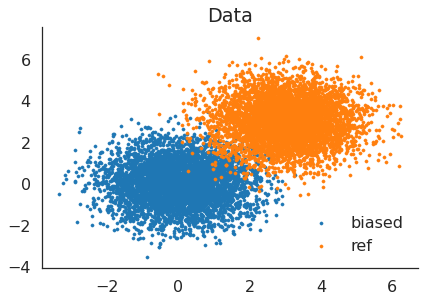

In [17]:
plt.scatter(p[:,0], p[:,1], s=10, label='biased')
plt.scatter(q[:,0], q[:,1], s=10, label='ref')

plt.legend()
sns.despine()
plt.tight_layout()
plt.title('Data')

In [18]:
p_rv = Normal(0, 1)
q_rv = Normal(3, 1)

In [19]:
log_p = p_rv.log_prob(torch.from_numpy(true_xs)).sum(-1)
log_q = q_rv.log_prob(torch.from_numpy(true_xs)).sum(-1)
true_log_r = log_q - log_p

In [20]:
true_log_r

tensor([-7.3387, -3.1581, -9.8828,  ..., 12.2517, 11.8001, 13.0449],
       dtype=torch.float64)

In [21]:
true_r = torch.exp(true_log_r)
true_r

tensor([6.4987e-04, 4.2507e-02, 5.1044e-05,  ..., 2.0934e+05, 1.3326e+05,
        4.6273e+05], dtype=torch.float64)

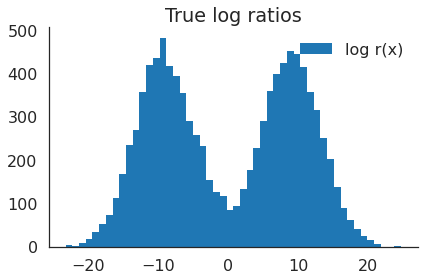

In [22]:
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
plt.title('True log ratios')

plt.legend()
sns.despine()
plt.tight_layout()

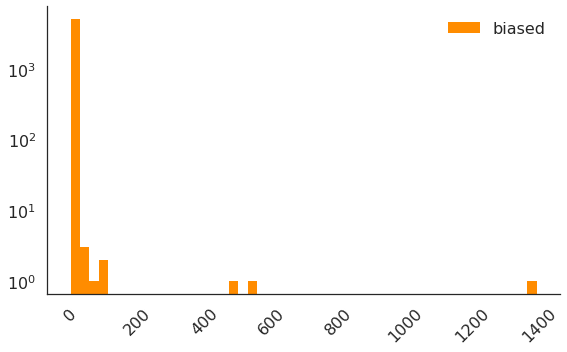

In [23]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_r.data.cpu().numpy()[0:5000], bins=50, log=True ,label='biased', color='darkorange')
# _ = plt.hist(new_ratios[y==1], bins=50, log=True, label='ref', alpha=0.5)
plt.xticks(rotation=45)

plt.legend()
sns.despine()
plt.tight_layout()

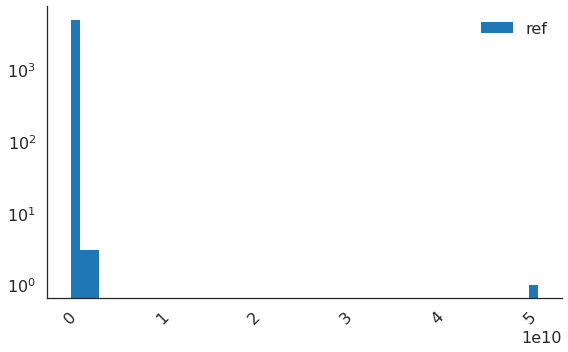

In [24]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_r.data.cpu().numpy()[5000:], bins=50, log=True ,label='ref')
plt.xticks(rotation=45)

plt.legend()
sns.despine()
plt.tight_layout()

### Compare the two

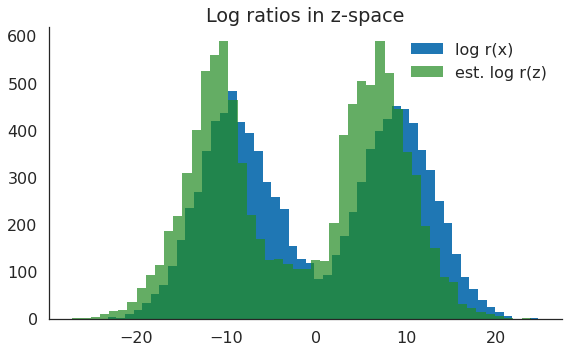

In [56]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
_ = plt.hist(np.log(z_ratios), bins=50, label='est. log r(z)', alpha=0.7, color='forestgreen')
plt.title('Log ratios in z-space')

plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()

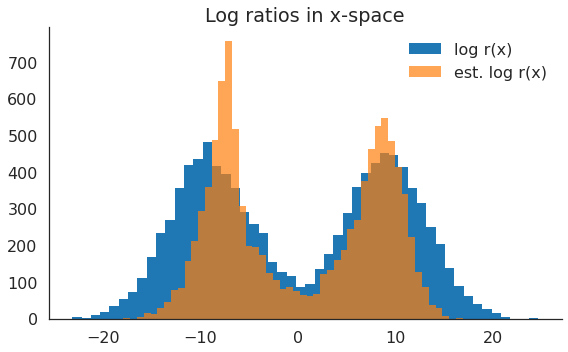

In [58]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='log r(x)')
_ = plt.hist(np.log(ratios), bins=50, label='est. log r(x)', alpha=0.7)
plt.title('Log ratios in x-space')

plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()

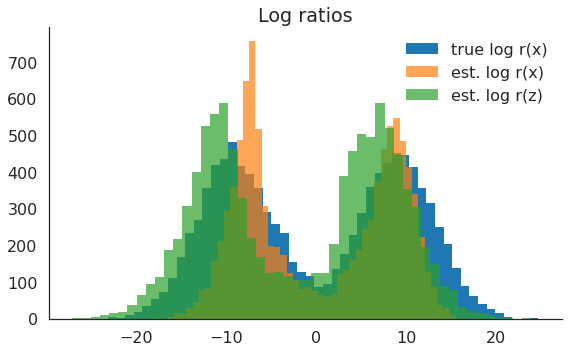

In [59]:
plt.figure(figsize=(8,5))
_ = plt.hist(true_log_r.data.cpu().numpy(), bins=50, label='true log r(x)')
_ = plt.hist(np.log(ratios), bins=50, label='est. log r(x)', alpha=0.7)
_ = plt.hist(np.log(z_ratios), bins=50, label='est. log r(z)', alpha=0.7)
plt.title('Log ratios')

plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()

------

# Can you scatter?

In [60]:
all_ratios = np.vstack([true_log_r, np.log(ratios), np.log(z_ratios)])
min_, max_ = all_ratios.min(), all_ratios.max()

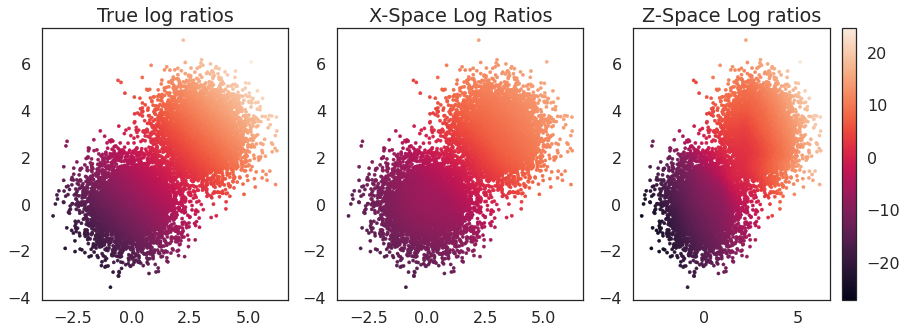

In [62]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(true_xs[:,0], true_xs[:,1], s=10, c=true_log_r)
plt.clim(min_, max_)
# plt.colorbar()
plt.title('True log ratios')

plt.subplot(1,3,2)
# x-space dre clf
plt.title('X-Space Log Ratios')
plt.scatter(x[:,0], x[:,1], s=10, c=np.log(ratios))
plt.clim(min_, max_)
# plt.colorbar()

# z-space
plt.subplot(1,3,3)
plt.title('Z-Space Log ratios')
plt.scatter(xhats[:,0], xhats[:,1], s=10, c=np.log(z_ratios))
plt.clim(min_, max_)
plt.colorbar()

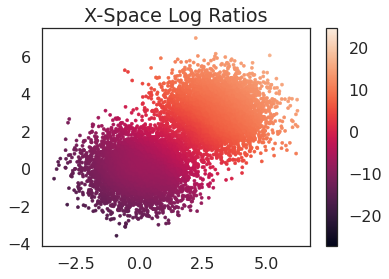

In [88]:
# x-space dre clf
plt.title('X-Space Log Ratios')
plt.scatter(x[:,0], x[:,1], s=10, c=np.log(ratios))
plt.clim(min_, max_)
plt.colorbar()

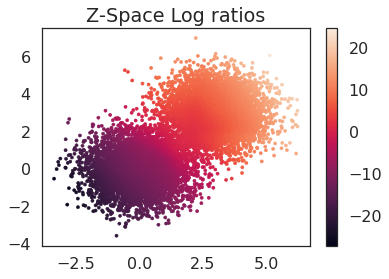

In [87]:
plt.title('Z-Space Log ratios')
plt.scatter(xhats[:,0], xhats[:,1], s=10, c=np.log(z_ratios))
plt.clim(min_, max_)
plt.colorbar()

----

# Look at x-space ratios

In [26]:
perc = 0.1

data = np.load('classification/results/gmm_perc{}/val_ratios.npz'.format(perc))
ratios = data['ratios']
y = data['d_labels']
x = data['data']

In [27]:
len(y)

10000

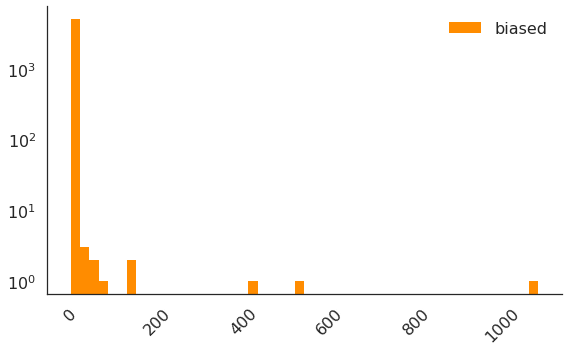

In [28]:
plt.figure(figsize=(8,5))
_ = plt.hist(ratios[y==0], bins=50, log=True ,label='biased', color='darkorange')
plt.xticks(rotation=45)

plt.legend()
sns.despine()
plt.tight_layout()

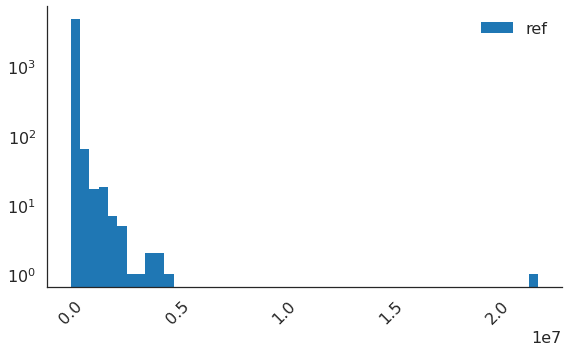

In [29]:
plt.figure(figsize=(8,5))
_ = plt.hist(ratios[y==1], bins=50, log=True, label='ref')
plt.xticks(rotation=45)

plt.legend()
sns.despine()
plt.tight_layout()

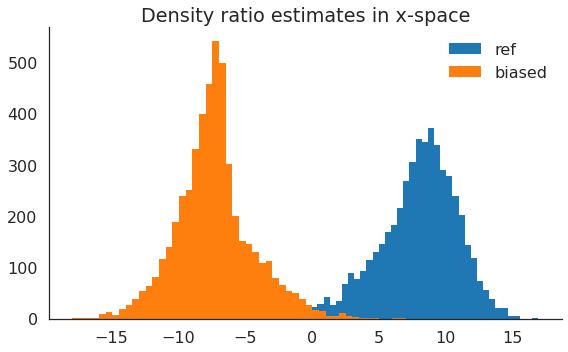

In [30]:
plt.figure(figsize=(8,5))

_ = plt.hist(np.log(ratios[y==1]), bins=50, label='ref')
_ = plt.hist(np.log(ratios[y==0]), bins=50, label='biased')

plt.title('Density ratio estimates in x-space')
plt.legend()
sns.despine()
plt.tight_layout()

# Z-Space

In [35]:
cd src

/atlas/u/kechoi/multi-fairgen/src


In [36]:
perc = 0.1

z_data = np.load('classification/results/gmm_z_perc0.1/val_ratios.npz'.format(perc))
z_ratios = z_data['ratios']
z_y = z_data['d_labels']
z_x = z_data['data']

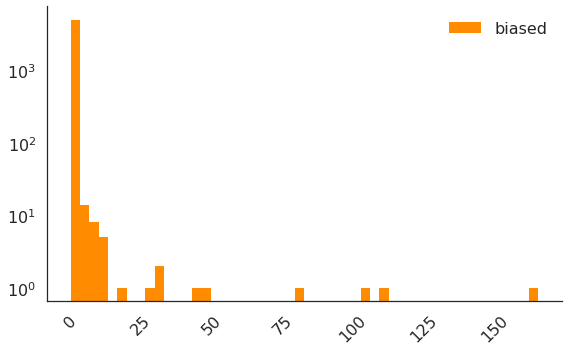

In [37]:
plt.figure(figsize=(8,5))
_ = plt.hist(z_ratios[z_y==0], bins=50, log=True ,label='biased', color='darkorange')
plt.xticks(rotation=45)

plt.legend()
sns.despine()
plt.tight_layout()

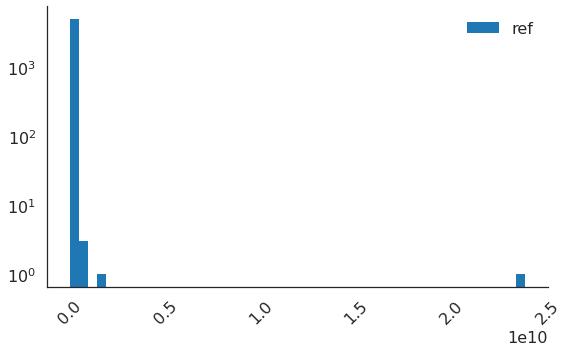

In [38]:
plt.figure(figsize=(8,5))
_ = plt.hist(z_ratios[z_y==1], bins=50, log=True, label='ref')
plt.xticks(rotation=45)

plt.legend()
sns.despine()
plt.tight_layout()

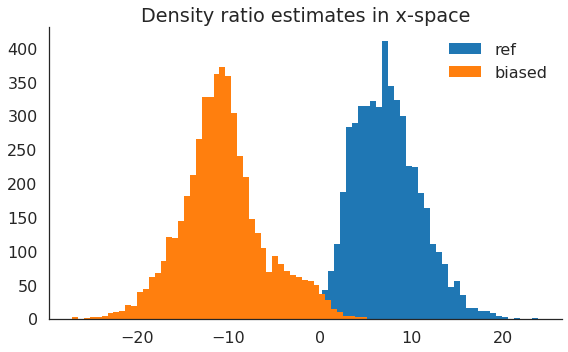

In [39]:
plt.figure(figsize=(8,5))

_ = plt.hist(np.log(z_ratios[z_y==1]), bins=50, label='ref')
_ = plt.hist(np.log(z_ratios[z_y==0]), bins=50, label='biased')

plt.title('Density ratio estimates in x-space')
plt.legend()
sns.despine()
plt.tight_layout()

### Can you load your flow?

In [40]:
cd flows/

/atlas/u/kechoi/multi-fairgen/src/flows


In [41]:
from models.maf import MAF

In [42]:
model = MAF(5, 
            2, 
            100, 
            1, 
            None, 
            'relu', 
            'sequential', 
            batch_norm=True)

In [43]:
import os

In [44]:
restore_file = 'results/gmm_perc0.1/'

In [45]:
state = torch.load(os.path.join(restore_file, "best_model_checkpoint.pt"), map_location='cuda')
model.load_state_dict(state['model_state'])

<All keys matched successfully>

In [46]:
z_x.shape

(10000, 2)

In [47]:
device = 'cuda'

In [48]:
model = model.to(device)
model.eval()
xhats = []

n_batches = len(z_x) // 100
for i in range(n_batches):
    z = torch.from_numpy(z_x[(i*100):(i+1)*100]).float().to(device)
    xhat, _ = model.inverse(z)
    xhats.append(xhat)

In [49]:
xhats = torch.cat(xhats)
xhats.size()

torch.Size([10000, 2])

In [50]:
xhats = xhats.data.cpu().numpy()

In [51]:
z_x

array([[ 0.6379252 ,  1.3289307 ],
       [ 1.630357  , -0.3899595 ],
       [ 0.815664  ,  0.95807195],
       ...,
       [ 0.5946584 , -0.14917868],
       [ 1.7397627 , -2.3054724 ],
       [-0.27442548, -0.62113315]], dtype=float32)

In [52]:
xhats

array([[ 0.99756   ,  1.8168535 ],
       [ 2.3119833 ,  1.6805084 ],
       [ 1.080422  ,  1.3980939 ],
       ...,
       [ 0.93495095,  0.02308352],
       [ 2.2784445 , -2.233815  ],
       [-0.05207784, -0.6078974 ]], dtype=float32)